In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 확인
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset 만들기
import keras
from keras.utils import to_categorical

# Detect Face
import cv2
from scipy.ndimage import zoom

# Model
from keras.models import Sequential
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization

from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/emotion/toy_project_filse/fer2013/fer2013.csv')

# 이미지 픽셀 list로 만들기
df['pixels'] = df['pixels'].apply(lambda pixel: np.fromstring(pixel, sep=' '))
df.head()

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


In [ ]:
# train test 나누기
train_df = df[df['Usage']=='Training']
test_df = df[df['Usage']=='PublicTest']
print(train_df.shape)
print(test_df.shape)

(28709, 3)
(3589, 3)


In [ ]:
shape_x = 48
shape_y = 48

# X_train, y_train, X_test, y_test split
X_train = train_df.iloc[:, 1].values # pixles
y_train = train_df.iloc[:, 0].values # emotion

X_test = test_df.iloc[:, 1].values # pixles
y_test = test_df.iloc[:, 0].values # emotion

# 전체데이터
X = df.iloc[:, 1].values # pixles
y = df.iloc[:, 0].values # emotion

# array([array([....])]) 구조를 바꾸기 위한 np.vstack
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

In [ ]:
# 4차원 데이터셋 만들기 (데이터개수, x축, y축, rgb)
X_train_ds = np.reshape(X_train, (X_train.shape[0], shape_x, shape_y, 1))
y_train_ds = np.reshape(y_train, (y_train.shape[0], 1))

X_test_ds = np.reshape(X_test, (X_test.shape[0], shape_x, shape_y, 1))
y_test_ds = np.reshape(y_test, (y_test.shape[0], 1))

print(X_train_ds.shape, y_train_ds.shape)
print(X_test_ds.shape, y_test_ds.shape)

(28709, 48, 48, 1) (28709, 1)
(3589, 48, 48, 1) (3589, 1)


In [ ]:
# 데이터타입 float로 변경
train_data = X_train_ds.astype('float32')
test_data = X_test_ds.astype('float32')

# 스케일링
train_data /= 225
test_data /= 225

# y데이터 원핫인코딩
train_labels_onehot = to_categorical(y_train_ds)
test_labels_onehot = to_categorical(y_test_ds)

# input_shape 설정
n_rows, n_cols, n_dims = X_train_ds.shape[1:]
input_shape = (n_rows, n_cols, n_dims)
print(input_shape)

(48, 48, 1)


Text(0.5, 1.0, 'Ground Truth : happy')

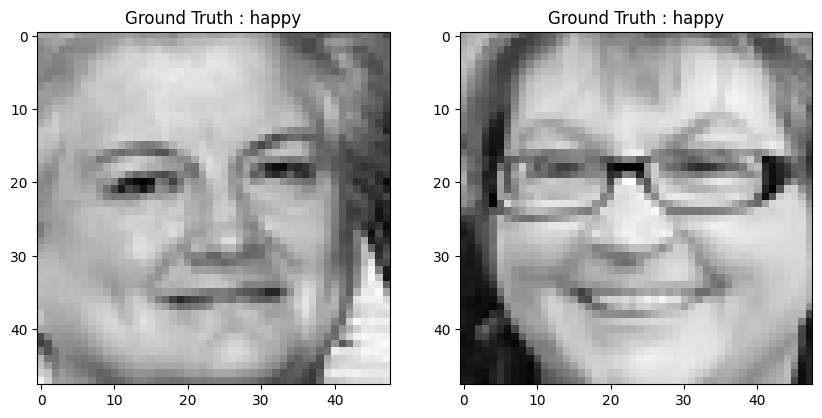

In [ ]:
# 라벨 숫자를 문자로 변경
def get_label(argument):
    labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
    return(labels.get(argument, 'Invalid emotion'))

# 데이터 시각화
plt.figure(figsize=[10,5])

# Train data 중 100번째 이미지
n=100

plt.subplot(121)
plt.imshow(np.squeeze(X_train_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[n]))))

# Test data 중 100번째 이미지
plt.subplot(122)
plt.imshow(np.squeeze(X_test_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[n]))))

In [ ]:
# 전체 이미지에서 얼굴을 찾아내는 함수
def detect_face(frame):

    # cascade pre-trained 모델 불러오기
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # RGB를 gray scale로 바꾸기
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # cascade 멀티스케일 분류
    detected_faces = face_cascade.detectMultiScale(gray,
                                                   scaleFactor = 1.1,
                                                   minNeighbors = 6,
                                                   minSize = (shape_x, shape_y),
                                                   flags = cv2.CASCADE_SCALE_IMAGE
                                                  )

    coord = []
    for x, y, w, h in detected_faces:
        if w > 100:
            sub_img = frame[y:y+h, x:x+w]
            coord.append([x, y, w, h])

    return gray, detected_faces, coord

In [ ]:
# 전체 이미지에서 찾아낸 얼굴을 추출하는 함수
def extract_face_features(gray, detected_faces, coord, offset_coefficients=(0.075, 0.05)):
    new_face = []
    for det in detected_faces:

        # 얼굴로 감지된 영역
        x, y, w, h = det

        # 이미지 경계값 받기
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        # gray scacle 에서 해당 위치 가져오기
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]

        # 얼굴 이미지만 확대
        new_extracted_face = zoom(extracted_face, (shape_x/extracted_face.shape[0], shape_y/extracted_face.shape[1]))
        new_extracted_face = new_extracted_face.astype(np.float32)
        new_extracted_face /= float(new_extracted_face.max()) # sacled
        new_face.append(new_extracted_face)

    return new_face

In [ ]:
def simple_model():
    model = Sequential()

    # Input layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))

    # Add layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Flatten
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(512, activation='relu'))

    # Output layer : n_classes=7
    model.add(Dense(7, activation='softmax'))

    return model

In [ ]:
model = simple_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 64)        36928     
                                                        

In [ ]:
# 각 레이어마다 어떻게 변화하는지 시각화

# 마지막 Dense 레이어 2개를 제외한 레이어별 out 담기
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# 시각화 할 때 어떤 레이어인지 확인할 수 있도록 레이어 이름 담기
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)

# 수지 얼굴 이미지 가져오기
suzy = cv2.imread('../../data/face_detect/e_neutral.jpeg')
gray, detected_faces, coord = detect_face(suzy)
face_zoom = extract_face_features(gray, detected_faces, coord)
face = face_zoom[0]

plt.subplot(211)
plt.title("Original Face")
plt.imshow(suzy)

plt.subplot(212)
plt.title("Extracted Face")
plt.imshow(face)

plt.show()

error: ignored

In [ ]:
# 수지 얼굴 모델에 넣어서 모델이 어떻게 작동하는지 시각화
to_predict = np.reshape(face.flatten(), (1,48,48,1))
res = model.predict(to_predict)
activations = activation_model.predict(to_predict)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
# 이미지 데이터 증강
datagen = ImageDataGenerator(zoom_range=0.2,          # 랜덤하게 이미지 줌 하는 비율
                             rotation_range=10,       # 램덤하게 이미지 회전하는 비율 (0도~180도)
                             width_shift_range=0.1,   # 랜덤하게 이미지 가로로 이동하는 비율
                             height_shift_range=0.1,  # 랜덤하게 이미지 세로로 이동하는 비율
                             horizontal_flip=True,    # 랜덤하게 이미지 수평 뒤집기
                             vertical_flip=False)     # 랜덤하게 이미지 수직 뒤집기

# 모델 학습을 위한 파라미터 설정
batch_size = 256
n_epochs = 200
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(datagen.flow(train_data, train_labels_onehot, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(train_data.shape[0]/float(batch_size))),
                              epochs=n_epochs,
                              validation_data=(test_data, test_labels_onehot)
                             )

Epoch 1/200
113/113 [==============================] - 25s 99ms/step - loss: 1.8171 - accuracy: 0.2457 - val_loss: 1.7973 - val_accuracy: 0.2561
Epoch 2/200
113/113 [==============================] - 11s 95ms/step - loss: 1.7656 - accuracy: 0.2669 - val_loss: 1.6816 - val_accuracy: 0.3168
Epoch 3/200
113/113 [==============================] - 11s 95ms/step - loss: 1.6856 - accuracy: 0.3269 - val_loss: 1.5570 - val_accuracy: 0.4090
Epoch 4/200
113/113 [==============================] - 11s 95ms/step - loss: 1.5946 - accuracy: 0.3734 - val_loss: 1.4176 - val_accuracy: 0.4514
Epoch 5/200
113/113 [==============================] - 11s 95ms/step - loss: 1.4898 - accuracy: 0.4238 - val_loss: 1.3603 - val_accuracy: 0.4831
Epoch 6/200
113/113 [==============================] - 11s 98ms/step - loss: 1.4196 - accuracy: 0.4495 - val_loss: 1.3108 - val_accuracy: 0.4909
Epoch 7/200
113/113 [==============================] - 11s 95ms/step - loss: 1.3615 - accuracy: 0.4744 - val_loss: 1.2415 - val_ac

In [ ]:
# 모델을 나중에 사용할 수 있도록 h5 파일로 저장.

model.save(f"/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/emotion/emotion_model_internet_acc_.h5", save_format='h5')

In [2]:
# 기존에 학습한 모델을 불러옵니다.
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/emotion/emotion_model_internet_acc_.h5')

Text(0.5, 1.0, 'Accuracy Curves')

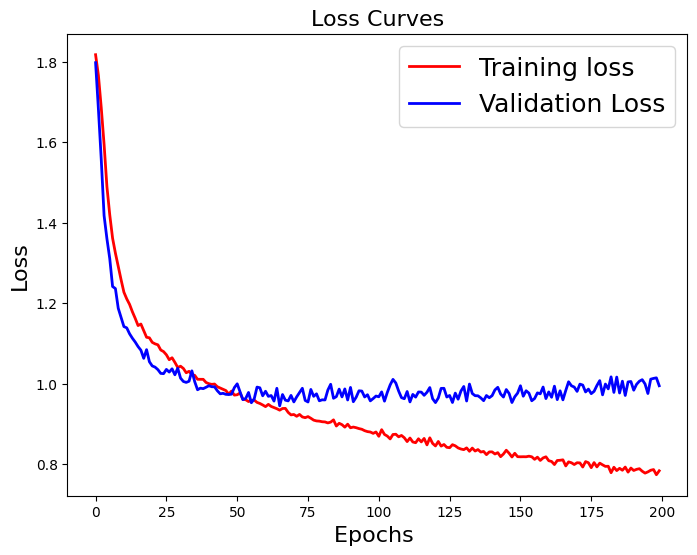

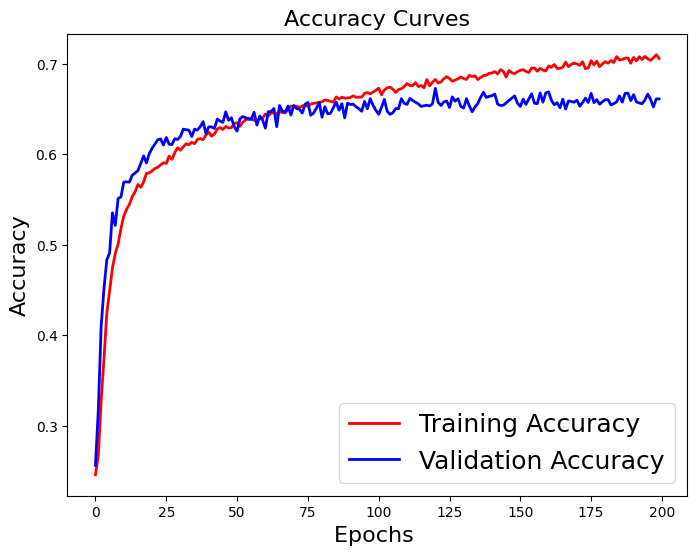

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

1/1 [==============================] - 0s 22ms/step


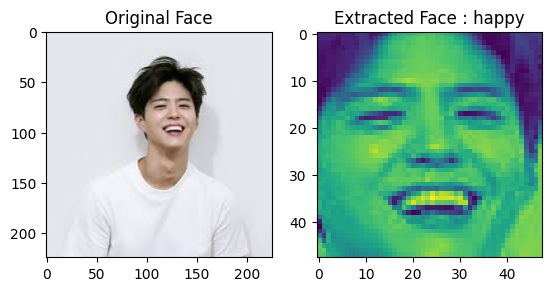

In [ ]:
# 원본이미지 확인
face = cv2.imread('/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/emotion/happy.jpg')

# 얼굴 추출
gray, detected_faces, coord = detect_face(face)
face_zoom = extract_face_features(gray, detected_faces, coord)

# 모델 추론
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'angry'
elif result == 1:
    emotion = 'disgust'
elif result == 2:
    emotion = 'fear'
elif result == 3:
    emotion = 'happy'
elif result == 4:
    emotion = 'sad'
elif result == 5:
    emotion = 'surprise'
elif result == 6:
    emotion = 'neutral'

# 시각화
plt.subplot(121)
plt.title("Original Face")
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_zoom[0])

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 확인
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset 만들기
import keras
from keras.utils import to_categorical

# Detect Face
import cv2
from scipy.ndimage import zoom

# Model
import torch
from keras.models import Sequential

#from tensorflow.keras.layers.convolutional import Conv2D, MaxPooling2D
#from tensorflow.keras.layers.core import Dense, Dropout, Activation, Flatten
#from tensorflow.keras.layers.normalization import batch_normalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

웹캠에 적용

In [ ]:
shape_x = 48
shape_y = 48

# 전체 이미지에서 얼굴을 찾아내는 함수
def detect_face(frame):

    # cascade pre-trained 모델 불러오기
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # RGB를 gray scale로 바꾸기
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # cascade 멀티스케일 분류
    detected_faces = face_cascade.detectMultiScale(gray,
                                                   scaleFactor = 1.1,
                                                   minNeighbors = 6,
                                                   minSize = (shape_x, shape_y),
                                                   flags = cv2.CASCADE_SCALE_IMAGE
                                                  )

    coord = []
    for x, y, w, h in detected_faces:
        if w > 100:
            sub_img = frame[y:y+h, x:x+w]
            coord.append([x, y, w, h])

    return gray, detected_faces, coord

In [ ]:
# 전체 이미지에서 찾아낸 얼굴을 추출하는 함수
def extract_face_features(gray, detected_faces, coord, offset_coefficients=(0.075, 0.05)):
    new_face = []
    for det in detected_faces:

        # 얼굴로 감지된 영역
        x, y, w, h = det

        # 이미지 경계값 받기
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        # gray scacle 에서 해당 위치 가져오기
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]

        # 얼굴 이미지만 확대
        new_extracted_face = zoom(extracted_face, (shape_x/extracted_face.shape[0], shape_y/extracted_face.shape[1]))
        new_extracted_face = new_extracted_face.astype(np.float32)
        new_extracted_face /= float(new_extracted_face.max()) # sacled
        new_face.append(new_extracted_face)

    return new_face

In [ ]:

# 인덱스번호로 웹캠연결 대부분 시스템적으로 0번부터 부여됨
video_capture = cv2.VideoCapture(0)

In [ ]:
while True:
    ret, frame = video_capture.read()
    if not ret:
        break

    #좌우 대칭 적용
    frame=cv2.flip(frame,1)

    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)



    for i, (x, y, w, h) in enumerate(faces):
        # Crop the face region
        face = gray[y:y+h, x:x+w]

        # 감정 예측
        emotion_image = cv2.resize(face, (48, 48), interpolation=cv2.INTER_AREA)
        emotion_input = emotion_image.reshape(-1, 48, 48, 1)
        pred=emotion_model.predict(emotion_input)
        pred_result=np.argmax(pred)

        # 각 라벨별 예측 정도 표시
        cv2.putText(frame,                                   # 텍스트를 표시할 프레임
                    "Angry: " + str(round(pred[0][0], 3)),   # 텍스트 표시 "감정: 예측 probablity", 소수점 아래 3자리
                    (10, 50),                                # 텍스트 위치
                    cv2.FONT_HERSHEY_SIMPLEX,                # 폰트 종류
                    1,                                       # 폰트 사이즈
                    (0, 0, 255),                             # 폰트 색상
                    2                                        # 폰트 두께
                   )
        cv2.putText(frame, "Disgust: " + str(round(pred[0][1], 3)), (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(frame, "Fear: " + str(round(pred[0][2], 3)), (10, 130), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(frame, "Happy: " + str(round(pred[0][3], 3)), (10, 170), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(frame, "Sad: " + str(round(pred[0][4], 3)), (10, 210), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(frame, "Surprise: " + str(round(pred[0][5], 3)), (10, 250), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(frame, "Neutral: " + str(round(pred[0][6], 3)), (10, 290), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # 예측값이 높은 라벨 하나만 프레임 옆에 표시
        if pred_result == 0:
            cv2.putText(frame, "Angry " + str(round(pred[0][0], 2)), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)
        elif pred_result == 1:
            cv2.putText(frame, "Disgust " + str(round(pred[0][1], 2)), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)
        elif pred_result == 2:
            cv2.putText(frame, "Fear " + str(round(pred[0][2], 2)), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)
        elif pred_result == 3:
            cv2.putText(frame, "Happy " + str(round(pred[0][3], 2)), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)
        elif pred_result == 4:
            cv2.putText(frame, "Sad " + str(round(pred[0][4], 2)), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)
        elif pred_result == 5:
            cv2.putText(frame, "Surprise " + str(round(pred[0][5], 2)), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)
        else:
            cv2.putText(frame, "Neutral " + str(round(pred[0][6], 2)), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the OpenCV windows
video_capture.release()
cv2.destroyAllWindows()
